Assignment:
    
AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input
  |
search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation
  |
search weather forcasting
1. get current weather
2. get weather forcast
  |
search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range
  |
calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
    | 
currency_converion
1. get exchnage rate
2. convert currancy
    | 
Itinery generation
1. get day plan
2. crete full itinery
    |
create Trip Summary
    |
Retun complete traval plan

Note: if you know the OOPS then design this entire system using object and class in modular fashion

In [45]:
# load env
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [46]:
# load llm model
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o", temperature=0)

In [47]:
from pydantic import BaseModel, HttpUrl, Field
from typing import Optional, List


class Location(BaseModel):
    address: Optional[str]
    city: Optional[str]
    state: Optional[str]
    country: Optional[str]
    latitude: Optional[float]
    longitude: Optional[float]


class SearchResultBase(BaseModel):
    id: str
    name: str
    description: Optional[str]
    category: str  # e.g., "attraction", "restaurant", etc.
    location: Location
    rating: Optional[float] = Field(ge=0.0, le=5.0)
    total_reviews: Optional[int]
    url: Optional[HttpUrl]
    image_url: Optional[HttpUrl]


class SearchAttraction(SearchResultBase):
    category: str = "attraction"
    entry_fee: Optional[str]
    opening_hours: Optional[str]


class SearchRestaurant(SearchResultBase):
    category: str = "restaurant"
    cuisine: Optional[List[str]]
    price_range: Optional[str]
    opening_hours: Optional[str]


class SearchActivity(SearchResultBase):
    category: str = "activity"
    duration: Optional[str]
    activity_type: Optional[str]


class SearchTransportation(SearchResultBase):
    category: str = "transportation"
    transport_type: Optional[str]  # e.g., "bus", "train", "car rental"
    operator_name: Optional[str]
    cost_estimate: Optional[str]


class SearchLocationResults(BaseModel):
    attractions: Optional[List[SearchAttraction]] = []
    restaurants: Optional[List[SearchRestaurant]] = []
    activities: Optional[List[SearchActivity]] = []
    transportation: Optional[List[SearchTransportation]] = []

In [48]:
#search attraction and activity
#1. search attraction
#2. search restaurant
#3. search activity
#4. search transportation
from langchain_core.tools import tool

@tool
def search_attraction_activity(location:str) -> SearchLocationResults:
    """
    search_attraction_activity
    """
    return SearchLocationResults

In [49]:
#search weather forecast
#1. get current weather
#2. get weather forecast
from langchain_core.tools import tool

@tool
def search_weather_forecast(location:str) ->str:
    """
    search_weather_forecast
    """
    pass

In [50]:
#search hotel costs
#1. search hotel
#2. estimate the hotel cost
#3. budget_range
from langchain_core.tools import tool

@tool
def search_hotel_cost(location:str) ->str:
    """
    search_hotel_cost
    """
    pass

In [51]:
#currency_conversion
#1. get exchange rate
#2. convert currency
from langchain_core.tools import tool

@tool
def currency_conversion(location:str) ->str:
    """
    currency_conversion
    """
    pass

In [52]:
# define calculator tools
from langchain_core.tools import tool

@tool
def add(a : int, b : int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The addition of a and b.
    """
    return a+b

@tool
def subtract(a : int, b : int) -> int:
    """
    Subtract two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The subtraction of a and b.
    """
    return a-b

@tool
def multiply(a : int, b : int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a*b

@tool
def divide(a : int, b : int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The division of a and b.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a/b

In [53]:
tools=[add,subtract,multiply,divide,search_attraction_activity,currency_conversion,search_hotel_cost,search_weather_forecast]
llm_with_tools=llm.bind_tools(tools)

In [54]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool_node=ToolNode(tools)
def travel_supervisor(state:MessagesState):
    last_message=state["messages"]
    print(f"##travel_supervisor## {last_message}")
    system_prompt="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
    user_query=[system_prompt]+last_message
    response=llm_with_tools.invoke(user_query)
    return {"messages":[response]}

In [55]:
graph=StateGraph(MessagesState)

graph.add_node("travel_supervisor",supervisor)

graph.add_node("tools",tool_node)

graph.set_entry_point("travel_supervisor")

graph.add_conditional_edges("travel_supervisor",tools_condition)

graph.add_edge("tools","travel_supervisor")

travel_planner=graph.compile()

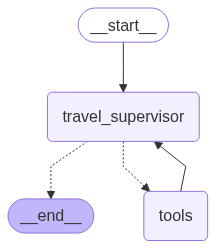

In [56]:
from IPython.display import Image, display
display(Image(travel_planner.get_graph().draw_mermaid_png()))